In [80]:
import random
import os
import os.path
from collections import defaultdict
import argparse
import json
from datetime import datetime
import locale
import yaml
import boto3
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torchvision.utils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from dataset import CoinrunDataset
from vae import VAE

In [121]:
# utils
def plot_images(imgs, ncols=1):
    nimgs = len(imgs)
    nrows = nimgs // ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axs.flat):
        ax.imshow(imgs[i])
    plt.tight_layout()
    plt.show()

In [64]:
# load data
obs = np.load('../dataset/data_initial_state.npz')['obs']
obs = obs.astype(np.float32) / 255.0  # obs[step][env][row][col][channel]
dataset = obs.reshape(-1, *obs.shape[2:])
print(f'shape {dataset.shape}, min {np.min(dataset)}, max {np.max(dataset)}')

shape (12800, 64, 64, 3), min 0.0, max 1.0


(96, 64, 64, 3)


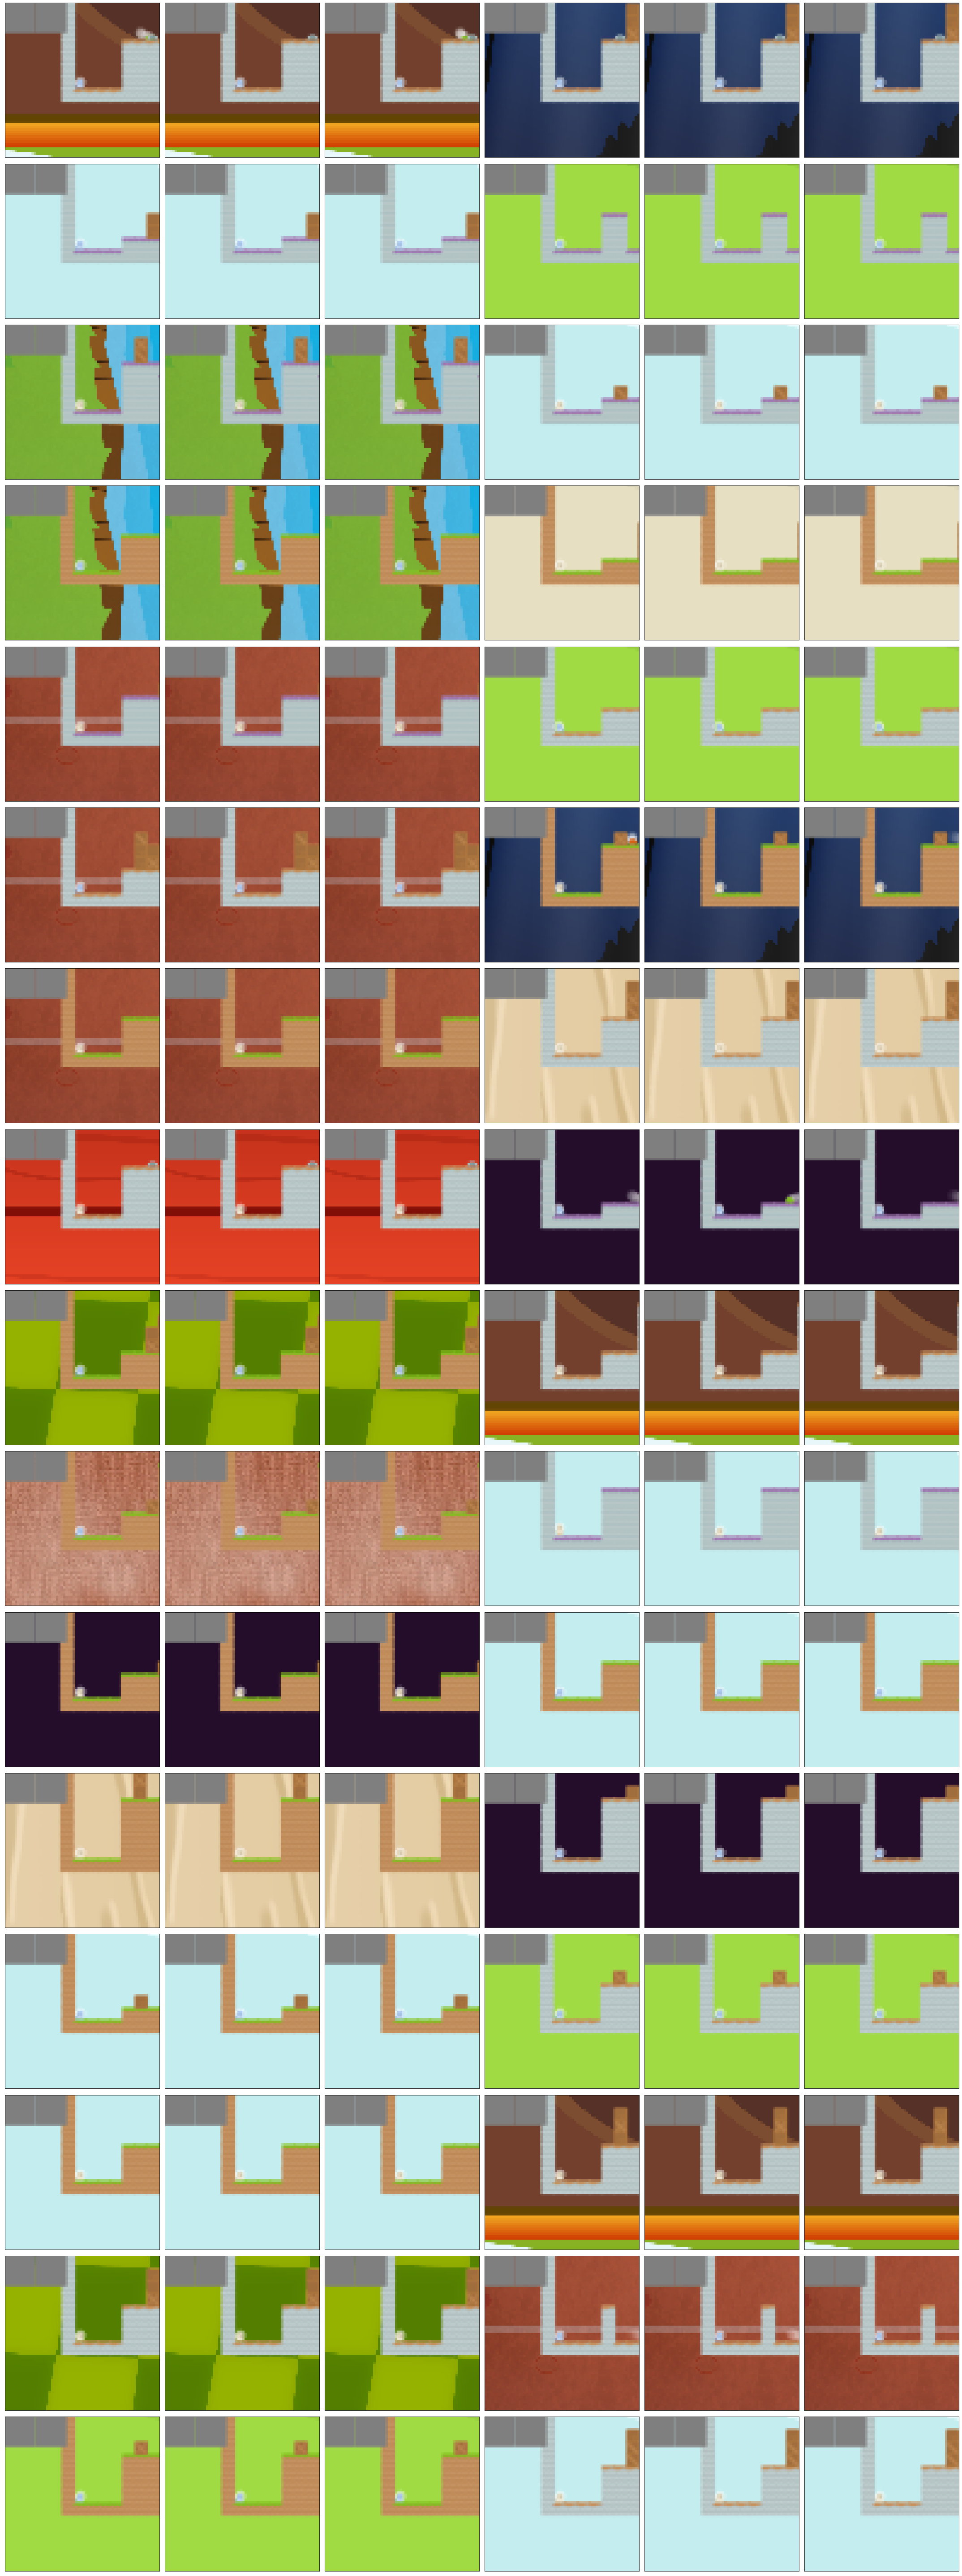

In [65]:
# visualize dataset
imgs = np.array([obs[np.random.choice(len(obs[i]), 3, replace=False)][:,i] for i in range(32)])
imgs = imgs.reshape(-1, *imgs.shape[2:])
print(imgs.shape)
plot_images(imgs, ncols=6)

In [79]:
# load VAE trained vanilla
vae_nobeta = VAE()
cp_nobeta = torch.load('../s3/09-01-2021/test_pipeline_11h19/checkpoints/epoch_199.checkpoint',
                       map_location=torch.device('cpu'))
vae_nobeta.load_state_dict(cp_nobeta['model_state_dict'])
vae_nobeta.eval()

# load VAE trained with beta linearly increasing from 0.5 to 30
vae_beta = VAE()
cp_beta = torch.load('../s3/10-01-2021/add_beta_03h21/checkpoints/epoch_199.checkpoint',
                     map_location=torch.device('cpu'))
vae_beta.load_state_dict(cp_beta['model_state_dict'])
vae_beta.eval() ;

**visualize reconstructions and encodings**

(from left to right: original image, reconstructed image, z-image)

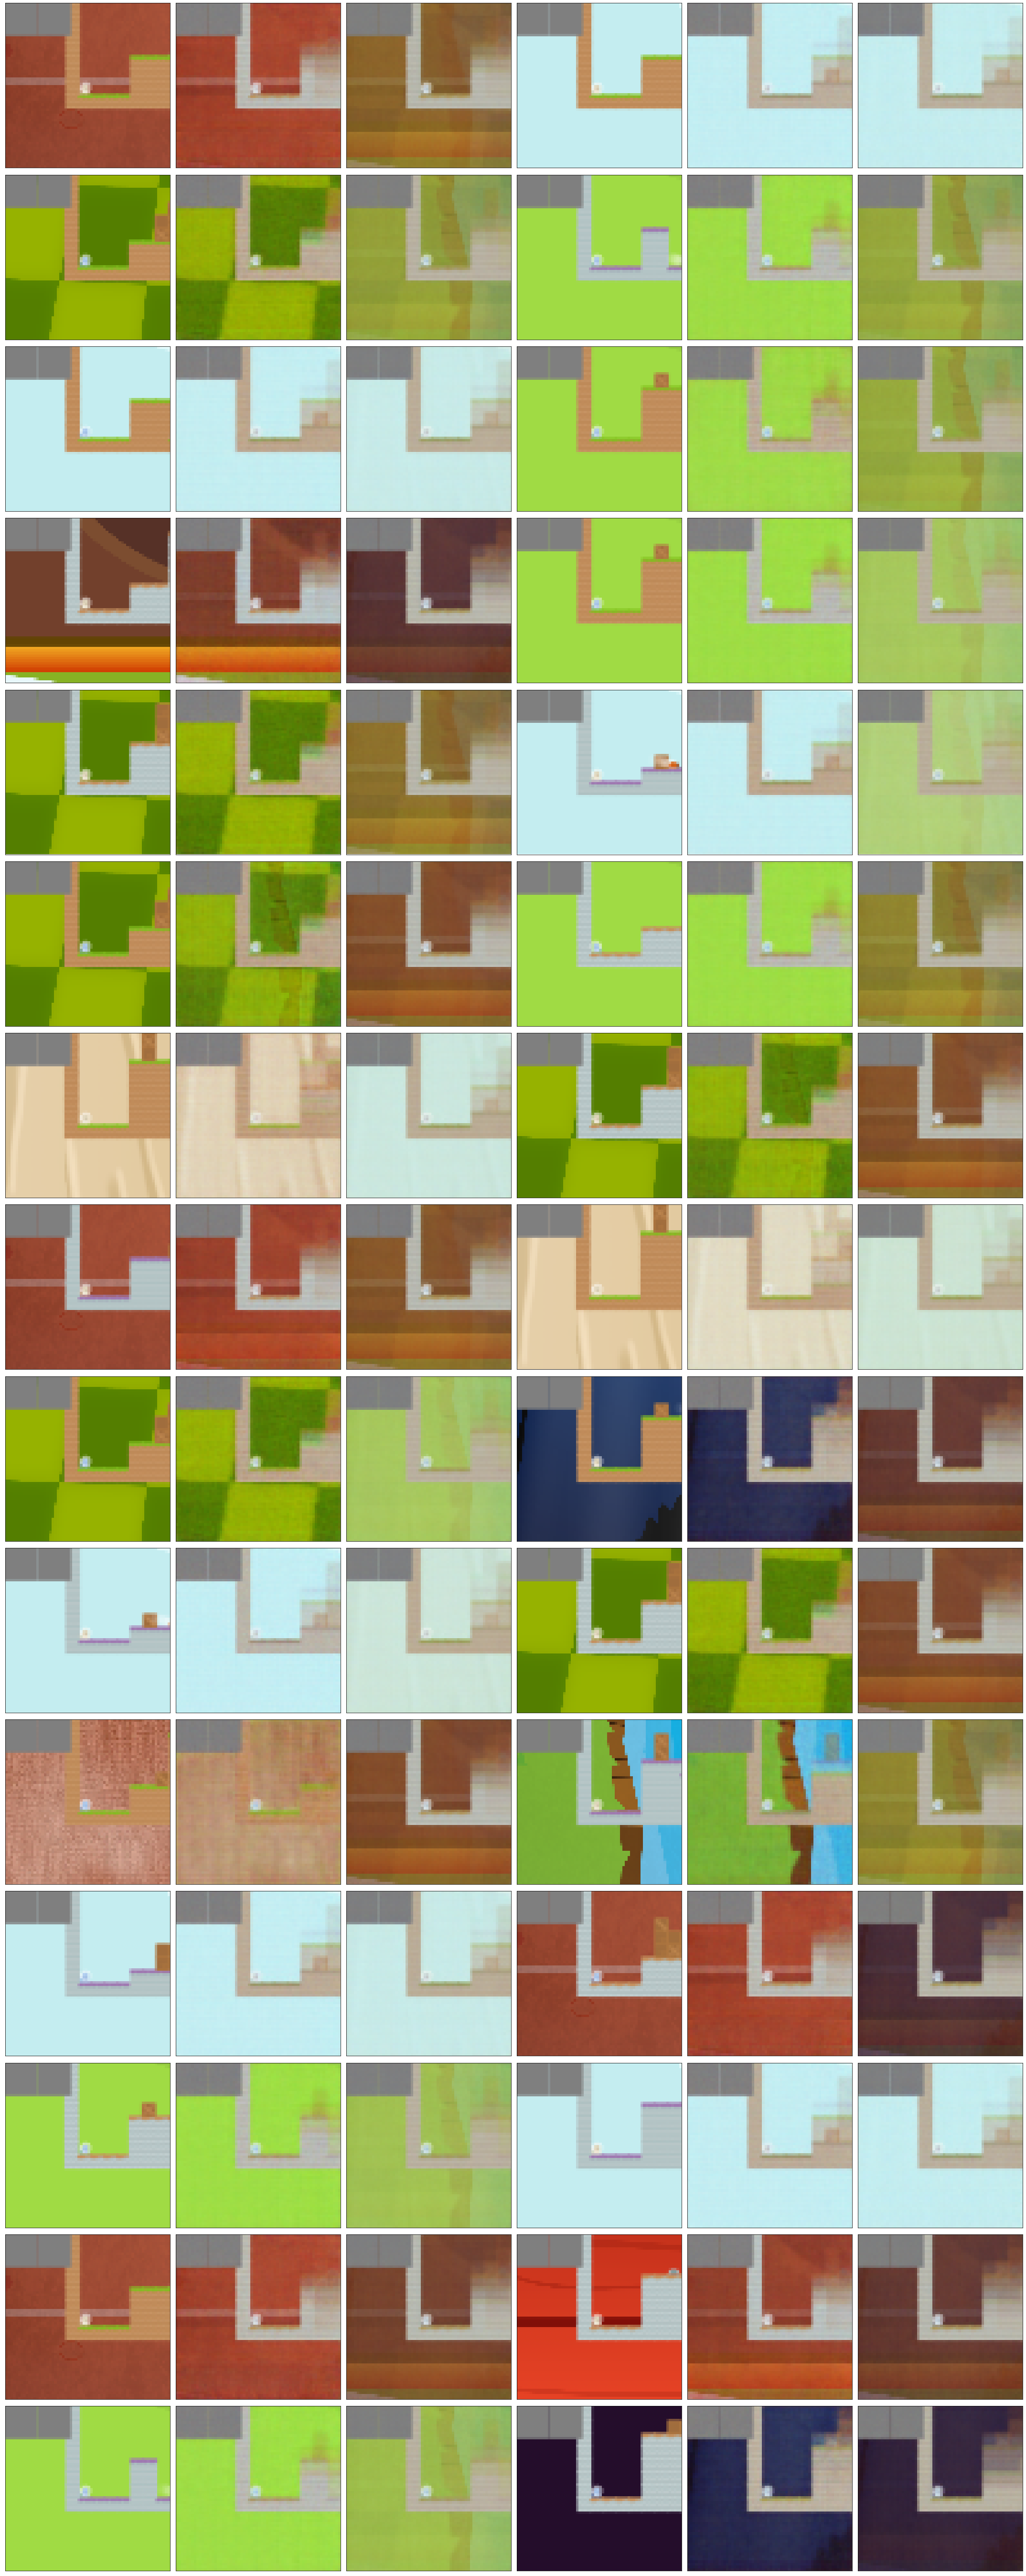

In [112]:
# plot reconstructions (img, vanilla vae reconstruction, beta vae reconstruction)
set_range = transforms.Lambda(lambda X: 2 * X - 1.)
transform = transforms.Compose([transforms.ToTensor(), set_range])

def tensorize(img):
    out = transforms.ToTensor()(img)
    out = transforms.Lambda(lambda X: 2 * X - 1.)(out)
    out = out.unsqueeze(0)
    return out

def untensorize(img, reduce=True):
    out = transforms.Lambda(lambda X: (X + 1) / 2)(img)
    out = out.detach().numpy()
    if reduce:
        out = out[0]
    out = np.transpose(out, (1, 2, 0))
    return out
    
imgs = []
for _ in range(30):
    img = random.choice(dataset)
    img_tensor = tensorize(img)
    img_r_nobeta = untensorize(vae_nobeta.generate(img_tensor))
    img_r_beta = untensorize(vae_beta.generate(img_tensor))
    imgs += [img, img_r_nobeta, img_r_beta]
    
plot_images(imgs, ncols=6)

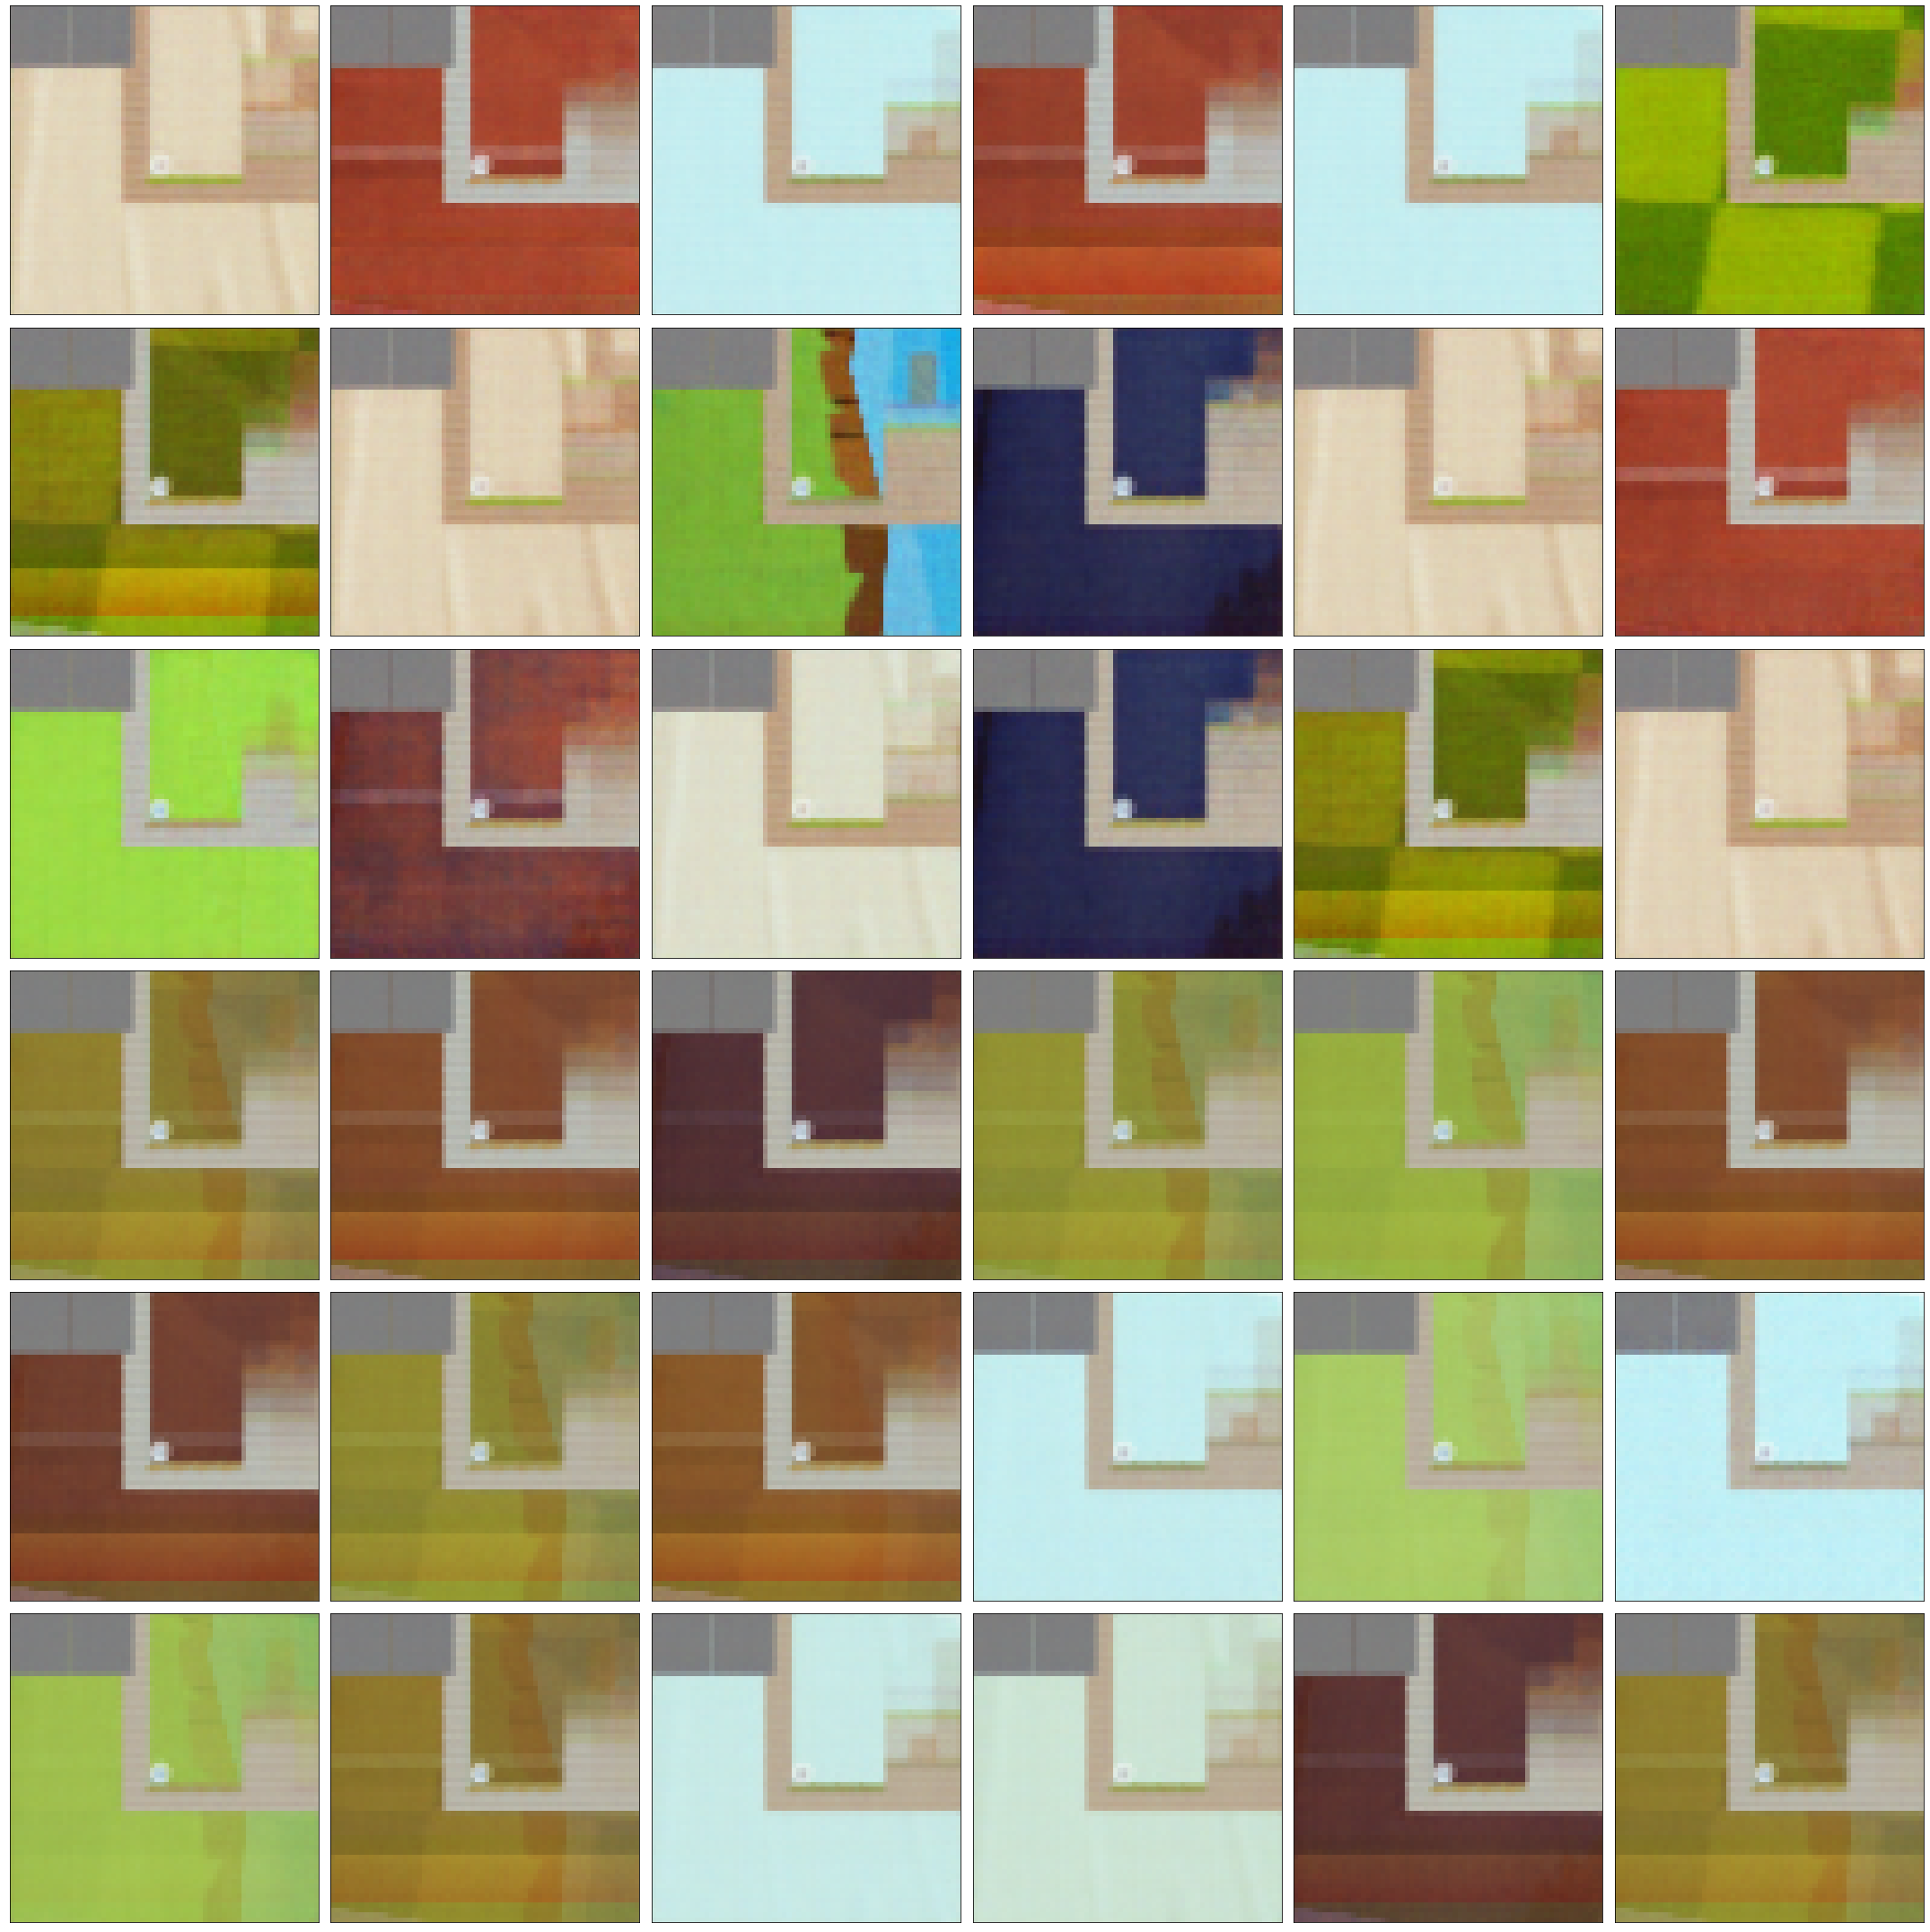

In [120]:
# samples
samples_nobeta = vae_nobeta.sample(18, torch.device('cpu'))
imgs_nobeta = [untensorize(s, reduce=False) for s in samples_nobeta]

samples_beta = vae_beta.sample(18, torch.device('cpu'))
imgs_beta = [untensorize(s, reduce=False) for s in samples_beta]

plot_images(imgs_nobeta + imgs_beta, ncols=6)

tensor([[-6.1476e-03,  6.0025e-03, -1.7619e-03, -5.6406e-03,  5.7919e-04,
          1.9647e-04,  5.2122e-05,  4.7545e-03,  2.9668e-03, -2.5123e-03,
         -6.3907e-03,  7.2973e-03,  4.6825e-05,  1.6651e-03,  3.7520e-03,
          3.4819e-03,  2.1641e-03, -1.1563e-02, -7.8085e-03,  3.6178e-03,
          1.0740e-02,  4.1603e-03, -1.9520e-03, -5.8420e-02, -4.0989e-03,
          5.4556e-03, -1.3854e-03, -4.2511e-03, -3.6501e-03, -1.2345e-03,
         -1.0113e-02,  7.0654e-03]], grad_fn=<AddmmBackward>)
tensor([[-1.7220e-04,  1.6891e-03,  9.3561e-05,  4.9224e-04, -8.4333e-04,
          2.7687e-03, -1.3740e-04,  3.3022e-03,  9.9070e-04,  2.4138e-03,
         -7.3620e-04, -2.3755e-03,  1.0662e-04,  2.0130e-03,  2.9373e-03,
          1.0769e-03,  2.2310e-04,  3.1476e-04, -2.6884e-03,  6.4344e-03,
          1.8314e-03,  2.4435e-03, -4.4343e-03, -2.2182e+00, -1.6452e-03,
         -5.7171e-04, -1.2156e-03, -1.9122e-03,  1.9150e-04, -2.9940e-03,
          6.1095e-03, -1.4033e-03]], grad_fn=<Addm

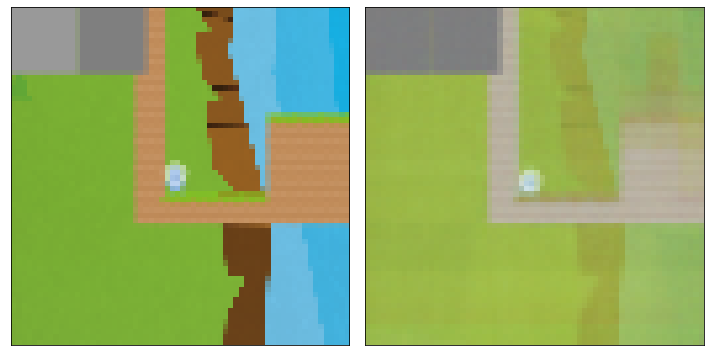

In [162]:
# disentanglement
img = dataset[6]

img_tensor = tensorize(img)
mu, log_var = vae_beta.encode(img_tensor)

z = vae_beta.reparameterize(mu, log_var)
img_r_tensor = vae_beta.decode(z)

print(mu)
print(log_var)
print(z)

img_r = untensorize(img_r_tensor)

plot_images([img, img_r], ncols=2)